In [16]:
learning_rate = 0.0015
weight_decay = 0.0001
batch_size = 4096
epochs = 5

### Downloader

In [ ]:
! pip install -q python-chess
! pip install -q kaggle

! mkdir ~/.kaggle
! echo '{"username":"threetnt","key":"7454bbee8bfde646c02f2a915ea5d02a"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d noobiedatascientist/lichess-september-2020-data
! unzip -p lichess-september-2020-data.zip Sept_20_analysis.txt > rawdata.csv

### Processing

In [2]:
import pandas as pd
import numpy as np
import io
import time
import os
from sklearn.utils import resample
import warnings

data = pd.read_csv('rawdata.csv', nrows=200000)
data.dropna(inplace=True, axis=0)
data.drop(labels=['GAME', 'Date', 'Event', 'Site', 'Termination', 'UTCTime', 'Total_moves', 'Game_flips', 'Game_flips_ts', 'WhiteRatingDiff', 'BlackRatingDiff'], axis=1, inplace=True)
# Some of the data here will leak the result, so we drop it

data = data[data['Result'] != '1/2-1/2']
data.head()

,BlackElo,ECO,Opening,Result,TimeControl,WhiteElo,Black_elo_category,White_elo_category,starting_time,increment,...,Black_ts_moves,White_ts_moves,Black_ts_blunders,White_ts_blunders,Black_ts_mistakes,White_ts_mistake,Black_long_moves,White_long_moves,Black_bad_long_moves,White_bad_long_moves
0,1143,A02,Bird Opening,0-1,300+0,1180,Low rating,Low rating,300.0,0.0,...,8,8,0,0,0,0,2,1,1,1
2,1933,C41,Philidor Defense,0-1,300+2,1485,High rating,Low rating,300.0,2.0,...,0,2,0,0,0,0,1,1,1,0
3,1710,B23,Sicilian Defense: Closed,0-1,180+2,2040,Low rating,High rating,180.0,2.0,...,18,0,4,0,0,0,3,1,1,0
4,1598,B03,Alekhine Defense,1-0,600+0,2163,Low rating,High rating,600.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,2207,E32,"Nimzo-Indian Defense: Classical Variation, Ker...",0-1,600+0,2062,High rating,High rating,600.0,0.0,...,0,0,0,0,0,0,1,1,0,1


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = [
    'BlackElo', 'WhiteElo', 
    'Black_blunders', 'White_blunders', 'Black_mistakes', 
    'White_mistakes', 'Black_inaccuracies', 'White_inaccuracies', 
    'Black_inferior_moves', 'White_inferior_moves', 'Black_ts_moves', 
    'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders', 
    'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 
    'White_long_moves', 'Black_bad_long_moves', 'White_bad_long_moves'
]

cat_cols = [
    'ECO', 'Opening', 'TimeControl', 'Black_elo_category',
    'White_elo_category', 'Game_type'
]

special_cols = [
    'starting_time', 'increment'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('spe', OneHotEncoder(categories='auto'), special_cols)
    ]
)

def transform_result(result):
    if result == '0-1':
        return -1
    elif result == '1-0':
        return 1
    else: # This will never happen but just in case
        return np.nan

data['Result'] = data['Result'].apply(transform_result).astype('float64')
data[special_cols] = data[special_cols].astype('int64')

Y = np.array(data['Result']).reshape(-1, 1)
data = data.drop(labels=['Result'], axis=1)
assert 'Result' not in data.columns
X = preprocessor.fit_transform(data)

In [4]:
np.unique(Y, return_counts=True)

(array([-1.,  1.]), array([93631, 99168], dtype=int64))

In [5]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1337, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1337, shuffle=True)
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

### Training

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# The main model
class ChessNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return self.forward(x).item()

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ChessNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay, momentum=0.9)
criterion = nn.MSELoss()


In [10]:
X = torch.tensor(X.todense(), dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

train, val, test = train_val_test_split(X, Y)
X_train, Y_train = train
X_val, Y_val = val
X_test, Y_test = test

dataset_train = TensorDataset(X_train, Y_train)
dataset_val = TensorDataset(X_val, Y_val)
dataset_test = TensorDataset(X_test, Y_test)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [54]:
lossgraph_train, lossgraph_val = [], []

for epoch in range(epochs):
    model.train()
    avloss_train, avloss_val, _track = 0, 0, 0
    for partial_epoch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossgraph_train.append(loss.item())
        avloss_train += loss.item()

        if partial_epoch % 10 == 0:
            model.eval()
            local_avloss_val = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred, y)
                    local_avloss_val += loss.item()
                    _track += 1
            lossgraph_val.append(local_avloss_val / len(val_loader))
            avloss_val += local_avloss_val
            model.train()

    avloss_train /= len(train_loader)
    avloss_val /= _track

    print(f'Epoch: {epoch+1}/{epochs}, Loss: {avloss_train:.4f}, Val Loss: {avloss_val:.4f}')

Epoch: 1/5, Loss: 0.7141, Val Loss: 0.7025
Epoch: 2/5, Loss: 0.3858, Val Loss: 0.3799
Epoch: 3/5, Loss: 0.3256, Val Loss: 0.3220
Epoch: 4/5, Loss: 0.3051, Val Loss: 0.3063
Epoch: 5/5, Loss: 0.3039, Val Loss: 0.3063


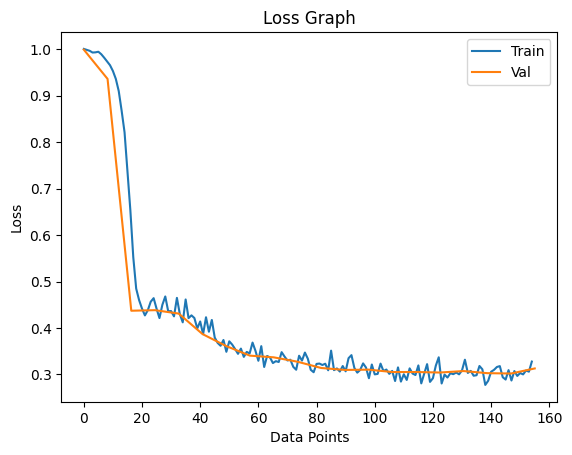

In [55]:

import matplotlib.pyplot as plt
plt.plot(lossgraph_train)
plt.plot(np.linspace(0, len(lossgraph_train), len(lossgraph_val)), lossgraph_val)
plt.legend(['Train', 'Val'])
plt.xlabel('Data Points')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.show()

In [38]:
torch.save(model.state_dict(), 'model.pth')

### Testing

In [45]:
def plot_weights_histogram(model):
    weights = []
    for param in model.parameters():
        weights.append(param.data.cpu().numpy().flatten())

    fig, ax = plt.subplots()
    ax.hist(np.concatenate(weights), bins=50)
    ax.set_xlabel('Weight value')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of neural network weights')
    plt.show()

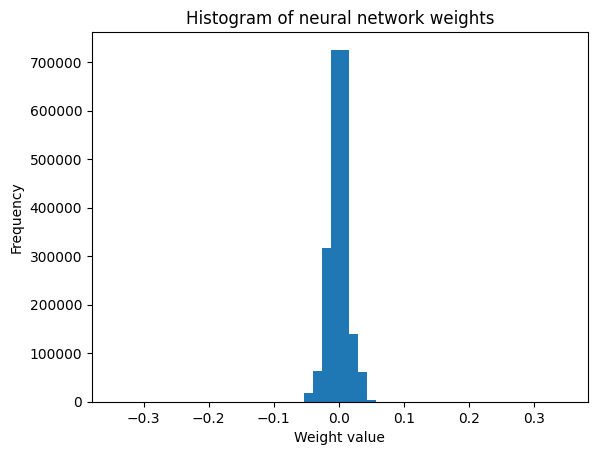

Test Loss: 0.3895

True Positives: 17421
False Positives: 1655
True Negatives: 17115
False Negatives: 2369


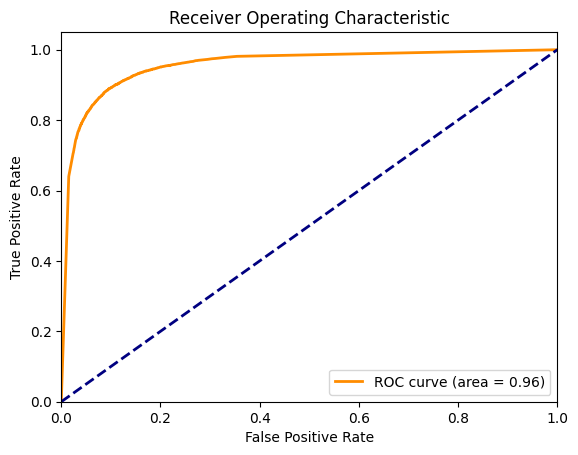

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def test(model, loader):
    model.eval()
    tp, fp, tn, fn = 0, 0, 0, 0
    y_true = []
    y_score = []

    with torch.no_grad():
        avloss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            avloss += loss.item()

            y_pred = y_pred.flatten()
            y = y.flatten()

            y_true.extend(y.cpu().numpy())
            y_score.extend(y_pred.cpu().numpy())

            tp += ((y_pred >= 0) & (y == 1)).sum().item()
            fp += ((y_pred >= 0) & (y == -1)).sum().item()
            tn += ((y_pred < 0) & (y == -1)).sum().item()
            fn += ((y_pred < 0) & (y == 1)).sum().item()

        avloss /= len(loader)
        print(f'Test Loss: {avloss:.4f}')
        print("")
        print(f'True Positives: {tp}')
        print(f'False Positives: {fp}')
        print(f'True Negatives: {tn}')
        print(f'False Negatives: {fn}')
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_weights_histogram(model)
test(model, test_loader)